## Tranfer Learning 실습 - VGG16모델로 ImageNet 데이터 학습하기

In [1]:
from __future__ import print_function
from PIL import Image
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import keras
from keras import models, layers, optimizers
from keras.applications import vgg16, inception_v3
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.imagenet_utils import decode_predictions
import cv2

%matplotlib inline

Using TensorFlow backend.


학습 및 검증 데이터 다운로드

In [2]:
%%capture
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Syhg0uzr555LdKnMGZFlVOEtBYfgDMQD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Syhg0uzr555LdKnMGZFlVOEtBYfgDMQD" -O data.zip && rm -rf /tmp/cookies.txt
! unzip -o data.zip

학습 데이터의 갯수를 확인합니다.

In [3]:
! ls -l train/*/*.jpg  | wc -l

600


In [4]:
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')

553467904/553467096 [==============================] - 6s 0us/step


In [5]:
def predictor(filename) :
  original = load_img(filename, target_size=(224, 224))
  numpy_image = img_to_array(original)
  image_batch = np.expand_dims(numpy_image, axis=0)
  # prepare the image for the VGG model
  processed_image = vgg16.preprocess_input(image_batch.copy())

  # get the predicted probabilities for each class
  predictions = vgg_model.predict(processed_image)
  label_vgg = decode_predictions(predictions)

  numpy_image = np.uint8(img_to_array(original)).copy()
  numpy_image = cv2.resize(numpy_image,(900,900))

  cv2.putText(numpy_image, "VGG16: {}, {:.2f}".format(label_vgg[0][0][1], label_vgg[0][0][2]) , (350, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)
  numpy_image = cv2.resize(numpy_image, (700,700))
  cv2.imwrite("images/{}_output.jpg".format(filename.split('/')[-1].split('.')[0]),cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR))

  plt.figure(figsize=[10,10])
  plt.imshow(numpy_image)
  plt.axis('off') 


40960/35363 [==================================] - 0s 0us/step


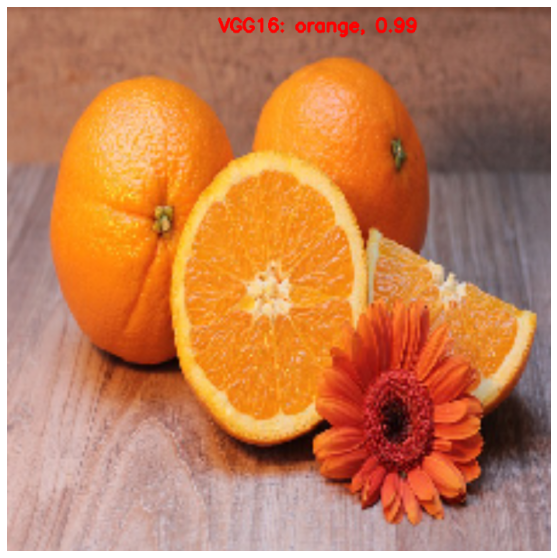

In [6]:
predictor('images/orange.jpg')

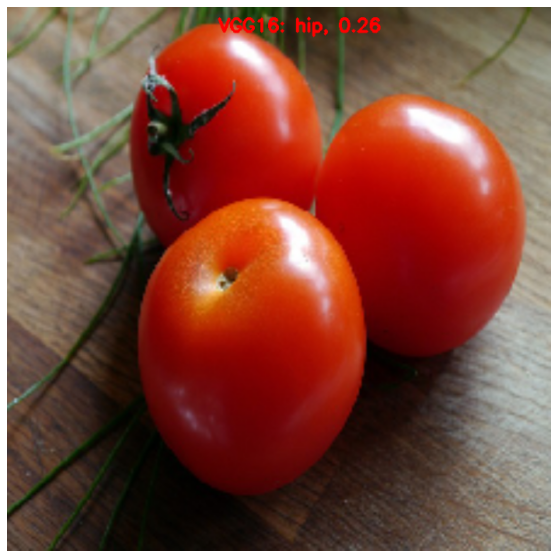

In [7]:
predictor('images/tomato.jpg')

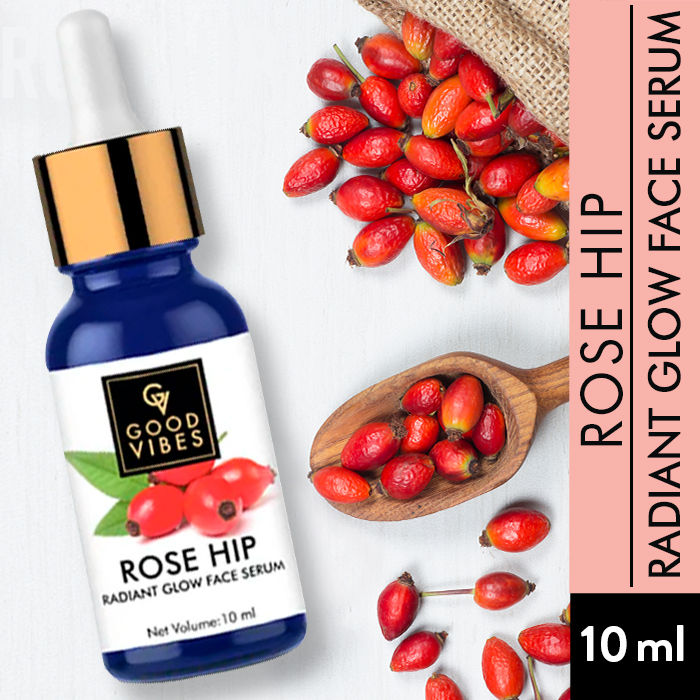

In [8]:
! wget --quiet https://media6.ppl-media.com/tr:h-750,w-750,c-at_max/static/img/product/152858/good-vibes-radiant-glow-face-serum-rose-hip-10-ml_9_display_1580466093_79e706b2.jpg -O hip.jpg
Image(filename='hip.jpg', width = 400, height = 400) 

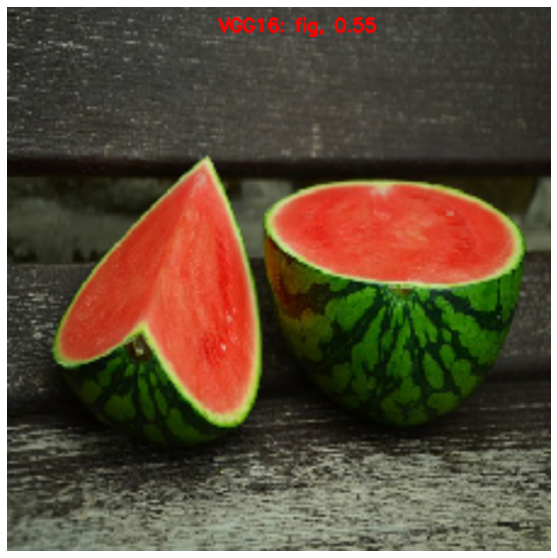

In [9]:
predictor('images/watermelon.jpg')

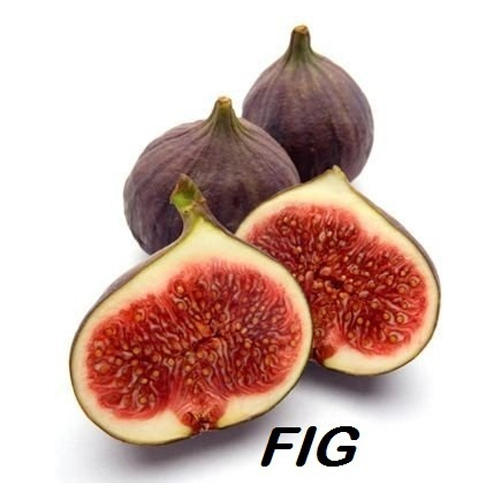

In [10]:

! wget --quiet https://5.imimg.com/data5/MK/MP/MY-42588315/fresh-fig-500x500.jpg -O fig.jpg >> /dev/null
Image(filename='fig.jpg', width = 400, height = 400) 

In [11]:
vgg_conv = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [12]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
train_dir = './train'
validation_dir = './validation'

nTrain = 600
nVal = 150

In [14]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,3))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

Found 600 images belonging to 3 classes.


In [15]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,3))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 150 images belonging to 3 classes.


In [16]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 600 samples, validate on 150 samples
Epoch 1/20
600/600 [==============================] - 4s 6ms/step - loss: 1.6600 - acc: 0.5917 - val_loss: 0.6802 - val_acc: 0.7200
Epoch 2/20
600/600 [==============================] - 4s 6ms/step - loss: 0.4762 - acc: 0.8200 - val_loss: 0.3371 - val_acc: 0.8800
Epoch 3/20
600/600 [==============================] - 4s 6ms/step - loss: 0.2973 - acc: 0.8883 - val_loss: 0.4620 - val_acc: 0.8400
Epoch 4/20
600/600 [==============================] - 4s 6ms/step - loss: 0.2040 - acc: 0.9333 - val_loss: 0.3993 - val_acc: 0.8733
Epoch 5/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1466 - acc: 0.9500 - val_loss: 0.3146 - val_acc: 0.9067
Epoch 6/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0838 - acc: 0.9683 - val_loss: 0.3998 - val_acc: 0.8933
Epoch 7/20
600/600 [==============================] - 4s 6ms/step - loss: 0.1508 - acc: 0.9633 - val_loss: 0.3353 - val_acc: 0.9067
Epoch 8/20
600/600 [==========

In [17]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [18]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [19]:
correct = np.where(predictions == ground_truth)[0]
print("No of correct = {}/{}".format(len(correct),nVal))

No of correct = 139/150


Original label:pumpkin, Prediction :pumpkin, confidence : 1.000


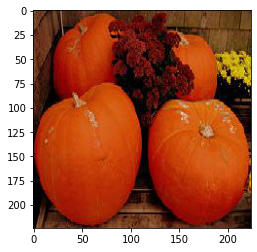

Original label:watermelon, Prediction :watermelon, confidence : 1.000


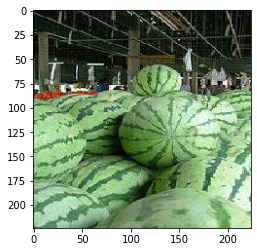

Original label:pumpkin, Prediction :pumpkin, confidence : 1.000


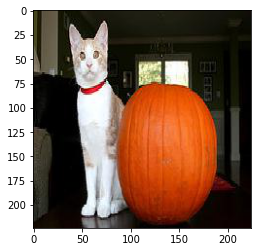

Original label:tomato, Prediction :tomato, confidence : 1.000


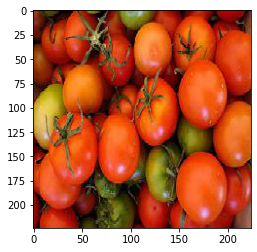

Original label:watermelon, Prediction :watermelon, confidence : 1.000


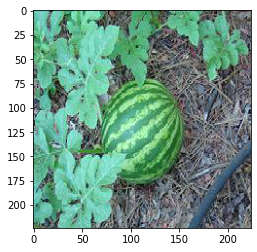

Original label:tomato, Prediction :tomato, confidence : 0.997


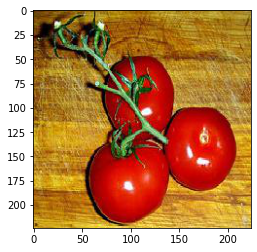

Original label:pumpkin, Prediction :pumpkin, confidence : 1.000


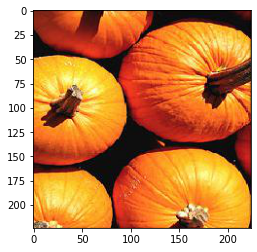

Original label:tomato, Prediction :tomato, confidence : 1.000


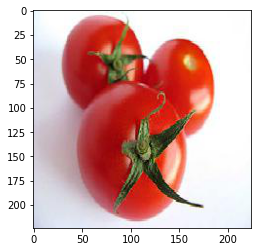

Original label:tomato, Prediction :tomato, confidence : 1.000


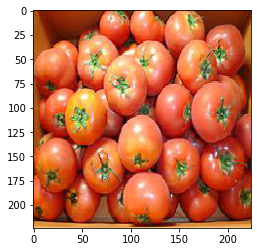

Original label:tomato, Prediction :tomato, confidence : 1.000


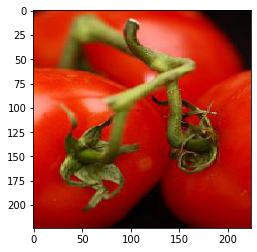

In [28]:
import random
for k in range(1,11):
    i = random.randrange(1,135)
    pred_class = np.argmax(prob[correct[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[correct[i]].split('/')[0],
        pred_label,
        prob[correct[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[correct[i]]))
    plt.imshow(original)
    plt.show()